### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [3]:
train_file_path = 'lab1_train.csv'
test_file_path = 'lab1_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')



First off I looked at the training data and noticed that the first 85000 points weren't the same as the rest of the dataset. Using DTW distances I expect to find anomalies where the shape of a certain signal is different to the normal shape it has.

C:\Users\quint\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


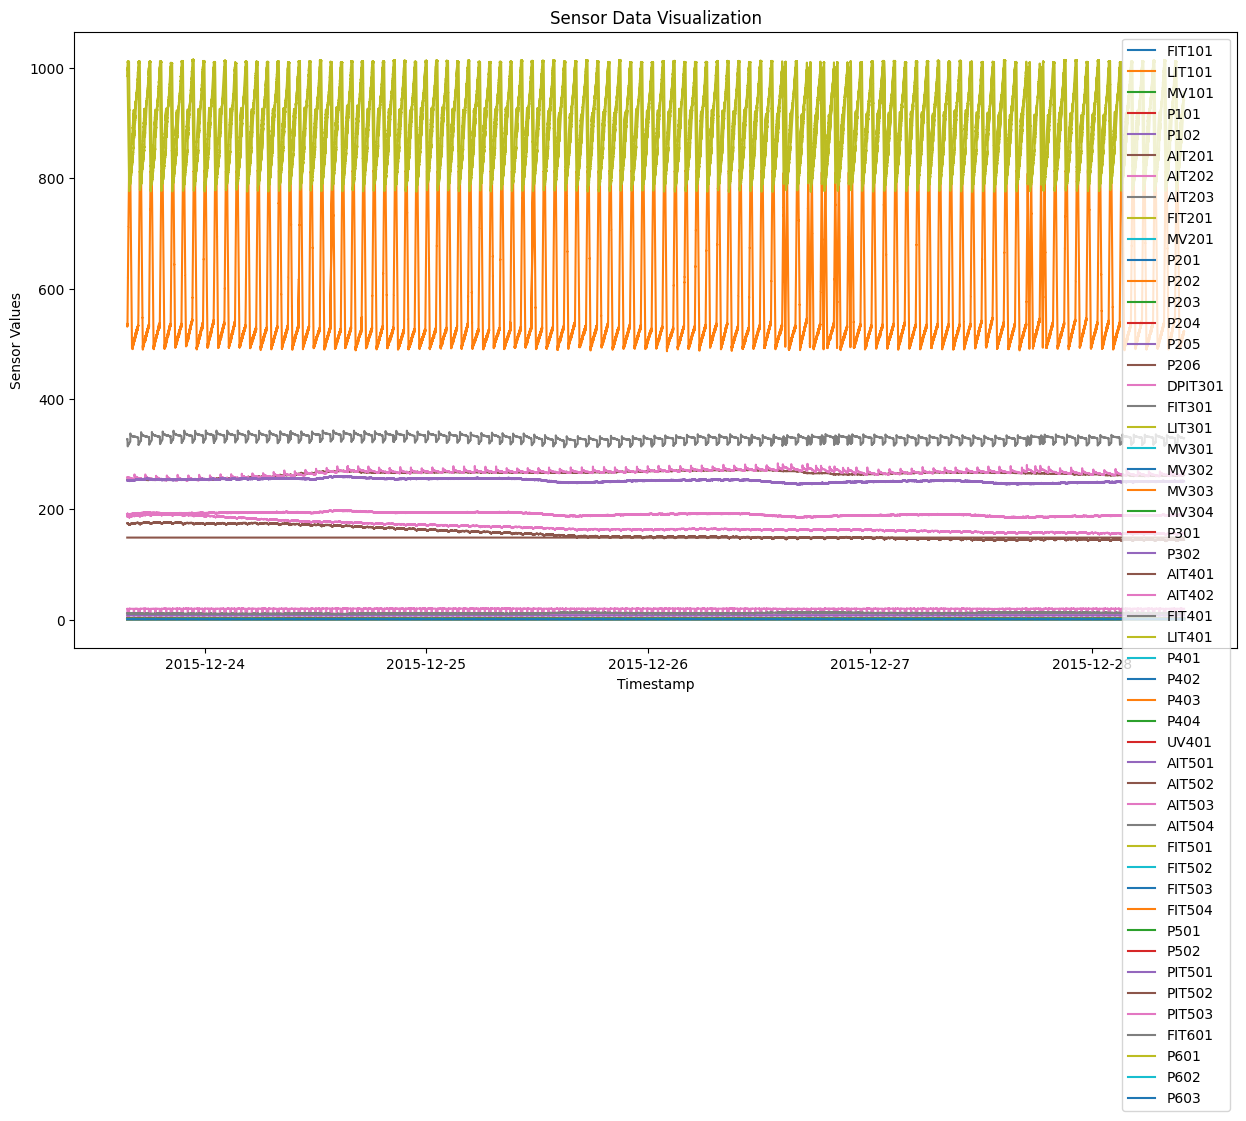

In [135]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

#visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
#visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
#visualize_sensor_data(train_data)
visualize_sensor_data(train_data, window=(85000, len(train_data))) #start point of normal data (not when starting up sensors)

I then looked at the test data to get an idea of how it looked like and what could possibly be an anomaly (such as the points between 31/12 and 01/01)

C:\Users\quint\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


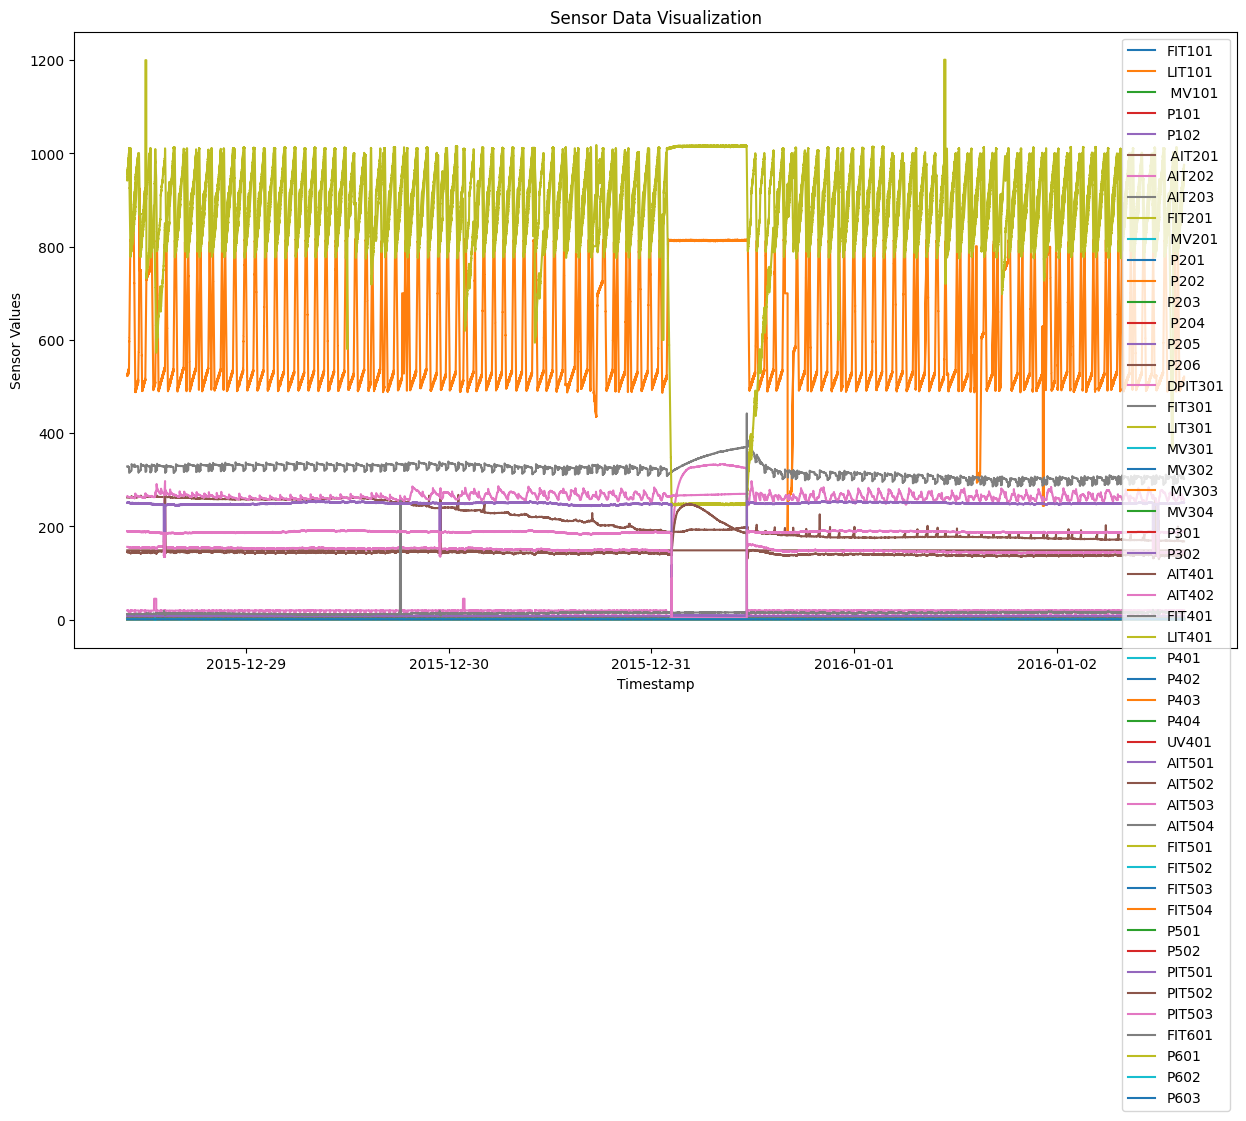

In [48]:
visualize_sensor_data(test_data)

Then I looked at different signals to find onel that displays interesting temporal behavior. I decided to use LIT101 because of the pattern it has below. I also made sure to use only the data points after 85000 from here on as the train data should not have any anomalies and have normal data.

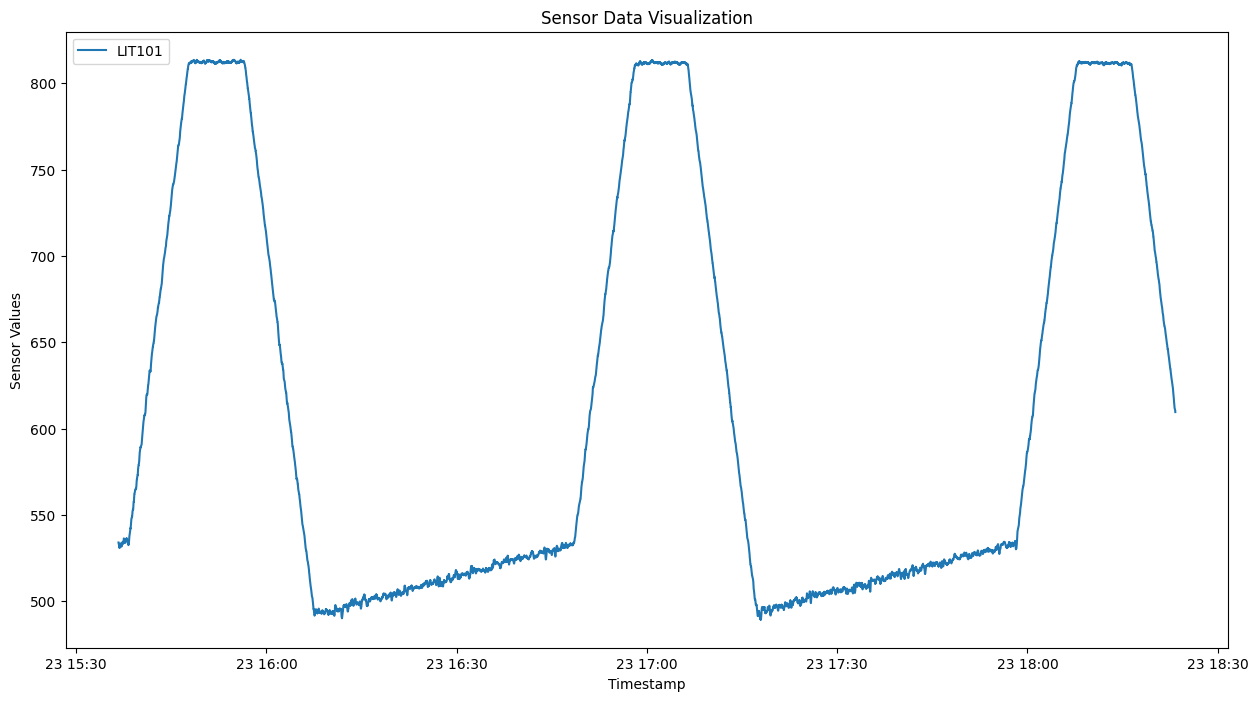

In [ ]:
no_start_train_data = train_data[85000:len(train_data)] #data not including start because this doesnt have the normal pattern
visualize_sensor_data(no_start_train_data, window=(0, 10000), sensors=['LIT101']) #pattern of sensor

Here I created the train windows. I first scaled down both the train and the test data by 100 to reduce runtime allowing for the pattern to be shown in less points. For these windows I decided to use a window length of 60 as this captures a bit more than a full pattern and a stride (jump between windows) of 40 to make sure I had enough windows to compute the residuals. These values (scaling down, stride) led to having 102 windows each having a size of 60.

In [ ]:
feature = no_start_train_data['LIT101'][::100] #Scale down by factor 100
feature_test = test_data['LIT101'][::100] #Also scale down by 100

#Train WINDOWS
train_windows = []
train_starts = []
window_length = 60 #amount of points in one window
for i in range(0, len(feature)-(window_length+1), 40): #jump with 40 for each window
    window = feature[i:i+window_length]
    train_windows.append(window)
    train_starts.append(i)
print('amount of windows: ', len(train_windows))
print('window size', train_windows[0].size)

amount of windows:  102
window size 60


Here you can see an example of one of these windows. Containing a bit more than 1 pattern.

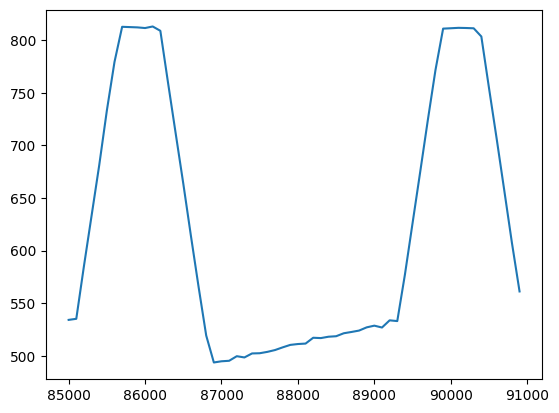

In [ ]:
plt.plot(train_windows[0]) #example of window

Here I created 2 functions: overlaps and dtw. Overlaps takes the start and end of two windows and makes sure there is no overlap between the two. Without this function the best distance will just be the window compared with itself or one using some of the same datapoints (much lower than it should be). Dtw calculates the dynamic time warping distance between the 2 windows.

In [179]:
def overlaps (a_start, a_end, b_start, b_end): #to make sure the best distance isnt just comparing with the same window
    return max(a_start, b_start) < min(a_end, b_end)


def dtw(window, window2): #Calculate dyanmic time warping distance of 2 windows
    n = window.size
    m = window2.size
    if(n == 0 or m == 0):
        return 0
    dtw = np.full((n+1, m+1), np.inf)
    dtw[0, 0] = 0
    for y in range(1, m+1):
        for x in range(1, n+1):
            dtw[x, y] = min(dtw[x-1, y], dtw[x, y-1], dtw[x-1, y-1]) + (window[x-1]- window2[y-1])**2

    return np.sqrt(dtw[n, m])

To get the train residuals I created new windows starting at point 10 (to get slightly different windows) with the same length and stride as the training windows. For each window I calculate all the dtw distances to the training windows and add the best distance to the train residuals. To do this I need to make sure there is no overlap between the windows. I also keep track of the train times to be able to scale back later.

In [180]:
train_residuals = []
train_times = []
for i in range(10, len(feature) - (window_length+1), 40): #start at 10 to get different windows
    window2 = feature[i:i+window_length] #second window
    best = np.inf #closest distance of not overlapping window
    for window, start in zip(train_windows, train_starts):
        if overlaps(i, i+window_length, start, start + window_length): #make sure it doesnt overlap
            continue
        dist = dtw(window.values, window2.values) #get distance between windows
        if dist < best: #if best distance change best
            best = dist
    train_residuals.append(best)
    train_times.append(i)


Here you can see the the residuas of the training windows with some spikes. This is due to not having a lot of windows (102, not alot of reference). And due to some windows being a bit different to the normal pattern.

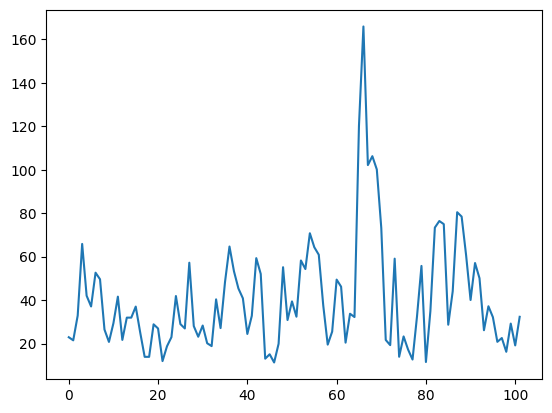

In [181]:
plt.plot(train_residuals) #residual of train windows

Here you can see the window at the point 20 where there is a low residual. It makes sense because this looks like a normal pattern.

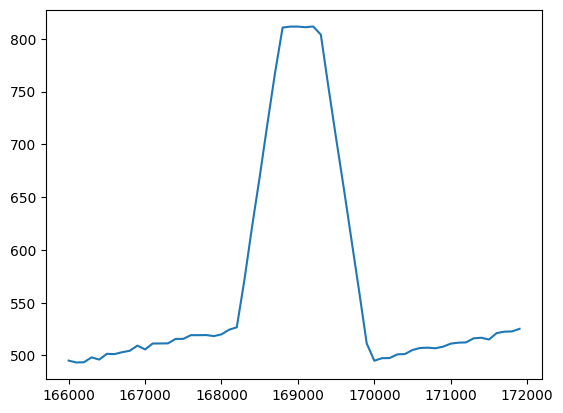

In [182]:
plt.plot(feature[train_times[20]: train_times[20]+60]) #example with low residual

And here you see the window of a point (68) with high residual. This also makes sense as it does not look like the normal pattern

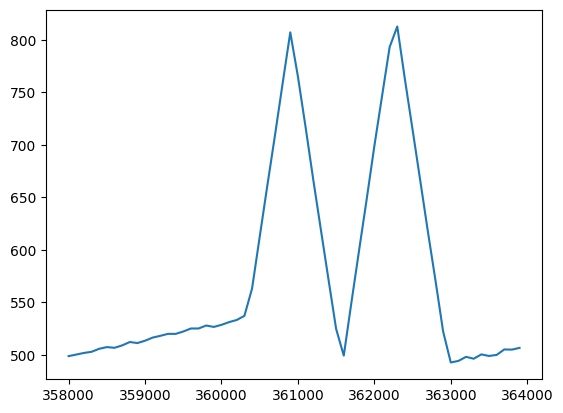

In [183]:
plt.plot(feature[train_times[68]: train_times[68]+60]) #example of high residual
#Understandable because it doesnt look like normal pattern

Here I get the test residuals by creating windows from the test data and comparing each of these windows to the all the training windows and adding the best distances. Here I do not need to check for overlaps because the test and training data are two different datasets

In [184]:
test_residuals = [] # Get test residuals
test_times = []
for i in range(0, len(feature) - (window_length+1), 40): #no need to check for overlap because you cant check the same (different datasets)
    window2 = feature_test[i:i+window_length]
    best = np.inf
    for window, start in zip(train_windows, train_starts):
        dist = dtw(window.values, window2.values)
        if dist < best:
            best = dist
    test_residuals.append(best)
    test_times.append(i)

Here I plot the test residuals and the train residuals and as you can see the anomalies are quite clear (where the red line is higher). As boundary (when something is an anomaly) I chose the max value of the train residuals.

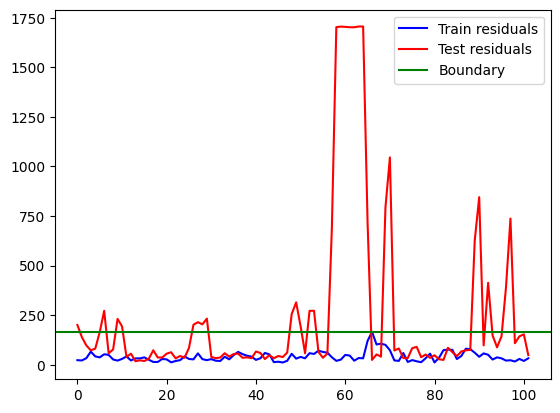

In [185]:
plt.plot(train_residuals, color="blue", label="Train residuals")
plt.plot(test_residuals, color="red", label="Test residuals")
plt.axhline(max(train_residuals), color="green", label="Boundary")
#everything above green line should be anomaly

plt.legend()
plt.show()

Here is an example of a window of the test data (at point 40) with a low residual. This makes sense because it looks like the normal pattern.

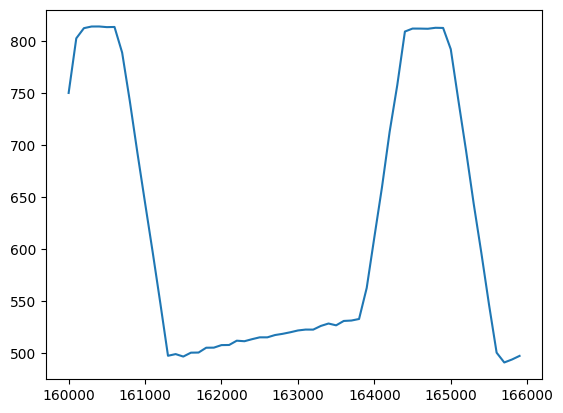

In [186]:
plt.plot(feature_test[test_times[40]:test_times[40]+60]) #example of low residual


And here is a window of the test data with a high residual (at point 60). This makes sense because this window looks nothing like the pattern.

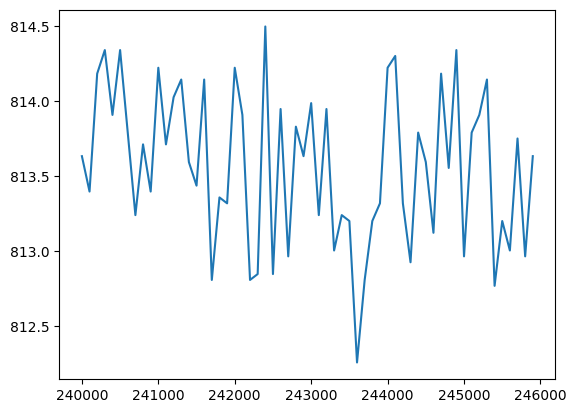

In [187]:
plt.plot(feature_test[test_times[60]:test_times[60]+60]) #example of high residual
#understandable because looks nothing like the pattern

To get the anomalies I decided to add the ranges of points between the start of an anomaly and the end as it is scaled down.

In [188]:
max_train = max(train_residuals) #highest train residual
anomalies = []
in_anomaly = False
for time, residual in zip(test_times, test_residuals):
    if residual > max_train: #then its an anomaly
        if(in_anomaly):
            end_index = time*100 #if already in an anomaly change end_index
        else:
            start_index = time*100 #otherwise set start index
            end_index = time*100
            in_anomaly = True
    else: #out of anomaly
        if(in_anomaly):
            anomalies.extend(range(start_index, end_index)) #add range to array
            in_anomaly = False #set in anomaly to false

In [189]:
anomalies

[36000,
 36001,
 36002,
 36003,
 36004,
 36005,
 36006,
 36007,
 36008,
 36009,
 36010,
 36011,
 36012,
 36013,
 36014,
 36015,
 36016,
 36017,
 36018,
 36019,
 36020,
 36021,
 36022,
 36023,
 36024,
 36025,
 36026,
 36027,
 36028,
 36029,
 36030,
 36031,
 36032,
 36033,
 36034,
 36035,
 36036,
 36037,
 36038,
 36039,
 36040,
 36041,
 36042,
 36043,
 36044,
 36045,
 36046,
 36047,
 36048,
 36049,
 36050,
 36051,
 36052,
 36053,
 36054,
 36055,
 36056,
 36057,
 36058,
 36059,
 36060,
 36061,
 36062,
 36063,
 36064,
 36065,
 36066,
 36067,
 36068,
 36069,
 36070,
 36071,
 36072,
 36073,
 36074,
 36075,
 36076,
 36077,
 36078,
 36079,
 36080,
 36081,
 36082,
 36083,
 36084,
 36085,
 36086,
 36087,
 36088,
 36089,
 36090,
 36091,
 36092,
 36093,
 36094,
 36095,
 36096,
 36097,
 36098,
 36099,
 36100,
 36101,
 36102,
 36103,
 36104,
 36105,
 36106,
 36107,
 36108,
 36109,
 36110,
 36111,
 36112,
 36113,
 36114,
 36115,
 36116,
 36117,
 36118,
 36119,
 36120,
 36121,
 36122,
 36123,
 36124,


Here I plotted the anomalies against the test data to be able to see where the anomalies are and why. The red points are the anomalies and they cover pretty much all the spikes. This makes sense because these are probably anomalies as they act more differently than normal. I probably wasnt able to catch all anomalies as I scaled the data down by 100 and only used one signal but I think most of them are in the array.

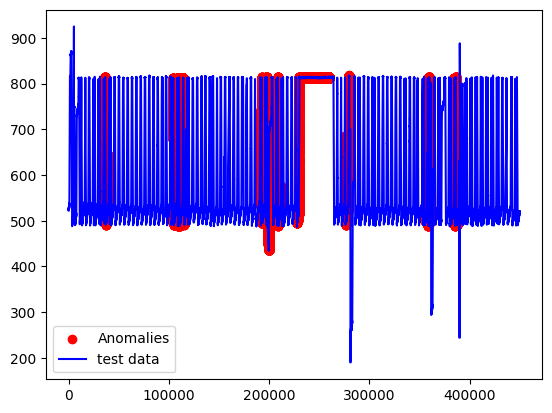

In [190]:
# Plot only the anomaly points (same x-coordinates, different color, point marker)
plt.scatter(anomalies, test_data['LIT101'][anomalies], color="red", label="Anomalies")

# Plot the full series (normal)
plt.plot(test_data['LIT101'], color="blue", label="test data")

plt.legend()
plt.show()